In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, KFold, GridSearchCV)
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix)
from IPython.display import SVG
from graphviz import Source
import matplotlib.pyplot as plt
import requests
import zipfile
import io
from imutils import paths
import os
import cv2
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz

In [2]:
url = "https://github.com/10sajan10/CS6830_Project7/raw/main/sateliteimage.zip"

response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
    
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall()
        print(f"Files extracted")

Download successful!
Files extracted


In [3]:
def extract_color_stats(image):

    B, G, R = cv2.split(image)

    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    std_R, std_G, std_B = np.std(R), np.std(G), np.std(B)

    features = [mean_R, mean_G, mean_B, std_R, std_G, std_B]

    return features

In [4]:
imagePaths = paths.list_images(r'sateliteimage/')
data = []
labels_str = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    features = extract_color_stats(image)
    data.append(features)

    # extract the class label from the file path and update the labels list
    label = imagePath.split(os.path.sep)[-2].split("/")[1]
    labels_str.append(label)

le = LabelEncoder()
labels = le.fit_transform(labels_str)

In [5]:
df = pd.DataFrame(data, columns=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'])
df['label'] = labels_str

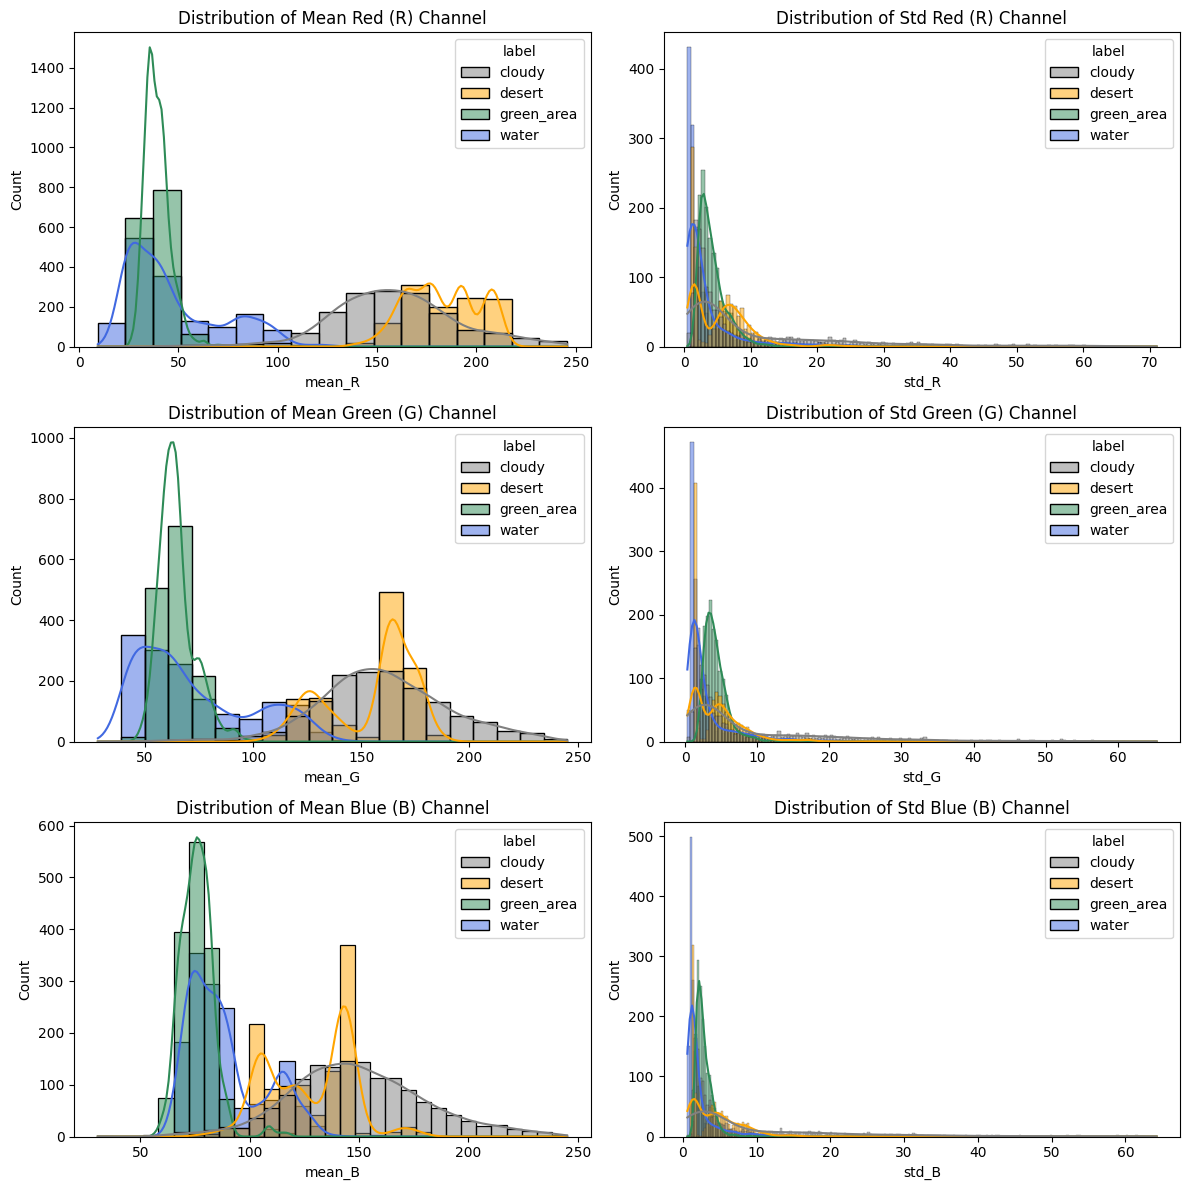

In [6]:
plt.figure(figsize=(12, 12))
color_mapping = {
    'cloudy': 'gray',
    'water': 'royalblue',
    'green_area': 'seagreen',
    'desert': 'orange'
}
# Plot for mean(R)
plt.subplot(3, 2, 1)
sns.histplot(data=df, x='mean_R', hue='label', palette=color_mapping, kde=True)
plt.title('Distribution of Mean Red (R) Channel')

# Plot for std(R)
plt.subplot(3, 2, 2)
sns.histplot(data=df, x='std_R', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Red (R) Channel')

# Plot for mean(G)
plt.subplot(3, 2, 3)
sns.histplot(data=df, x='mean_G', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Mean Green (G) Channel')

# Plot for std(G)
plt.subplot(3, 2, 4)
sns.histplot(data=df, x='std_G', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Green (G) Channel')

# Plot for mean(B)
plt.subplot(3, 2, 5)
sns.histplot(data=df, x='mean_B', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Mean Blue (B) Channel')

# Plot for std(B)
plt.subplot(3, 2, 6)
sns.histplot(data=df, x='std_B', hue='label',palette=color_mapping, kde=True)
plt.title('Distribution of Std Blue (B) Channel')

plt.tight_layout()
plt.show()

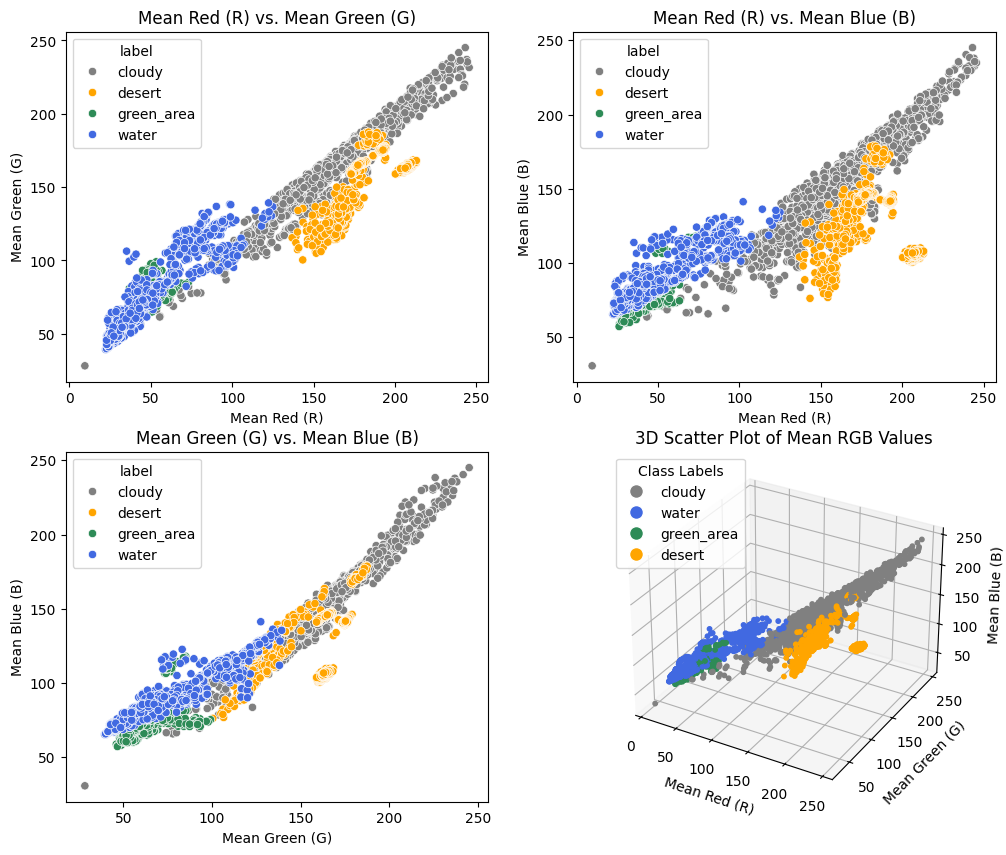

In [7]:
plt.figure(figsize=(12, 10))
color_mapping = {
    'cloudy': 'gray',
    'water': 'royalblue',
    'green_area': 'seagreen',
    'desert': 'orange'
}
df['color'] = df['label'].map(color_mapping)

# Plot for mean_R vs mean_G
plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x='mean_R', y='mean_G', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Green (G)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Green (G)')

# Plot for mean_R vs mean_B
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='mean_R', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Red (R) vs. Mean Blue (B)')
plt.xlabel('Mean Red (R)')
plt.ylabel('Mean Blue (B)')

# Plot for mean_G vs mean_B
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='mean_G', y='mean_B', hue='label', palette=color_mapping)
plt.title('Mean Green (G) vs. Mean Blue (B)')
plt.xlabel('Mean Green (G)')
plt.ylabel('Mean Blue (B)')


ax = plt.subplot(2, 2, 4, projection='3d')  # Set the 3D projection here

# Scatter plot with specified colors
ax.scatter(df['mean_R'], df['mean_G'], df['mean_B'], 
           color=df['color'],  # Use the color from the mapping
           s=10,  # Size of points
           alpha=1)  # Transparency

# Labels
ax.set_xlabel('Mean Red (R)')
ax.set_ylabel('Mean Green (G)')
ax.set_zlabel('Mean Blue (B)')
ax.set_title('3D Scatter Plot of Mean RGB Values')

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[label], markersize=10) 
           for label in color_mapping]
ax.legend(handles, color_mapping.keys(), title="Class Labels")


In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [24]:
treeclf = DecisionTreeClassifier(max_depth=4,)
treeclf.fit(trainX, trainY)

DecisionTreeClassifier(max_depth=4)

In [25]:
predictions = treeclf.predict(testX)

Confusion Matrix of Logistic Regression:
[[286  27   6   9]
 [ 10 217   0   0]
 [  0   0 246  38]
 [  2   0  33 253]]


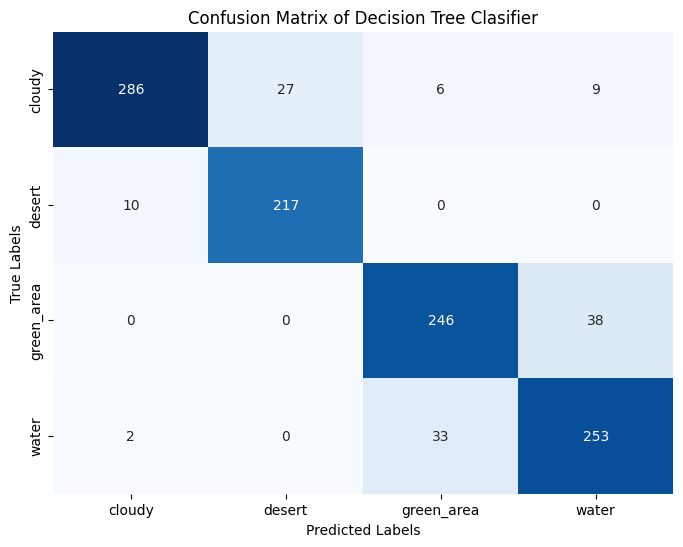

In [26]:
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Decision Tree Clasifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

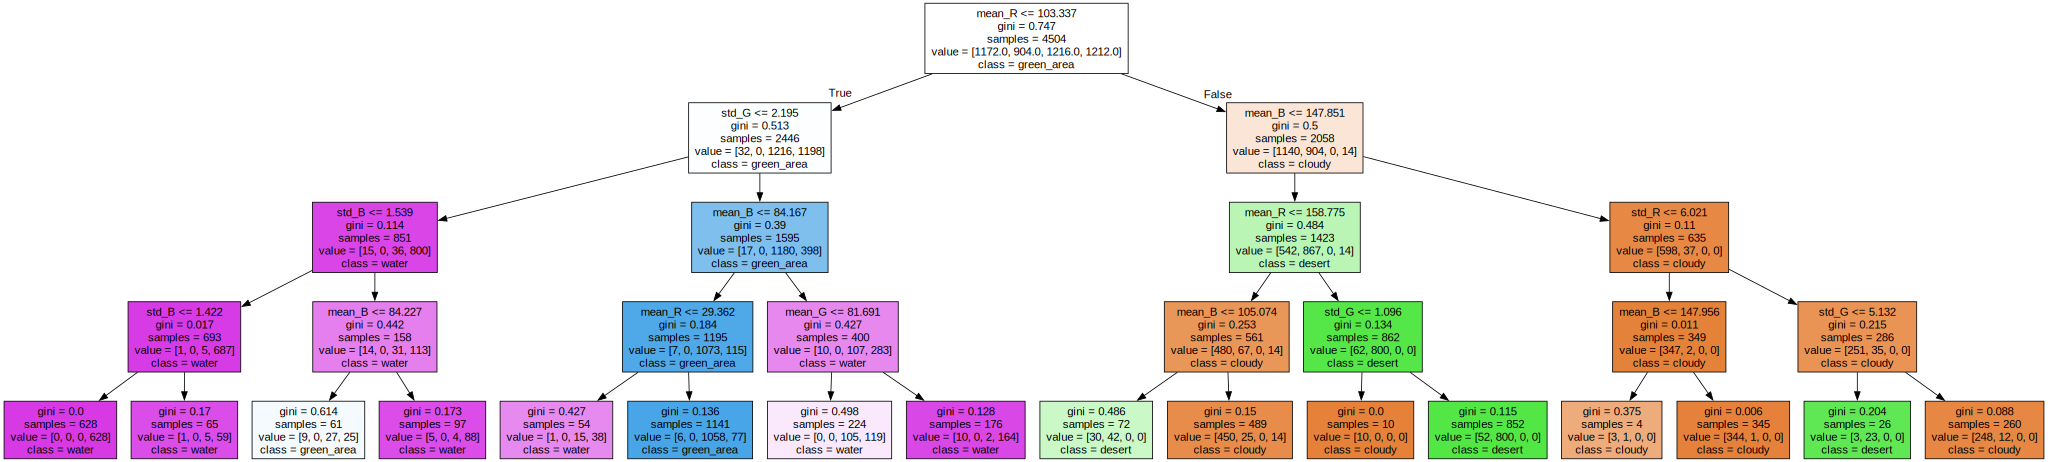

In [27]:
from sklearn import tree
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'],
                                    class_names=le.classes_, filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

In [28]:
treeclf.feature_importances_

array([0.56516868, 0.01337217, 0.20103322, 0.0015564 , 0.21295715,
       0.00591238])

Confusion Matrix of Logistic Regression:
[[294  19   6   9]
 [ 28 199   0   0]
 [  0   0 254  30]
 [  2   0  33 253]]


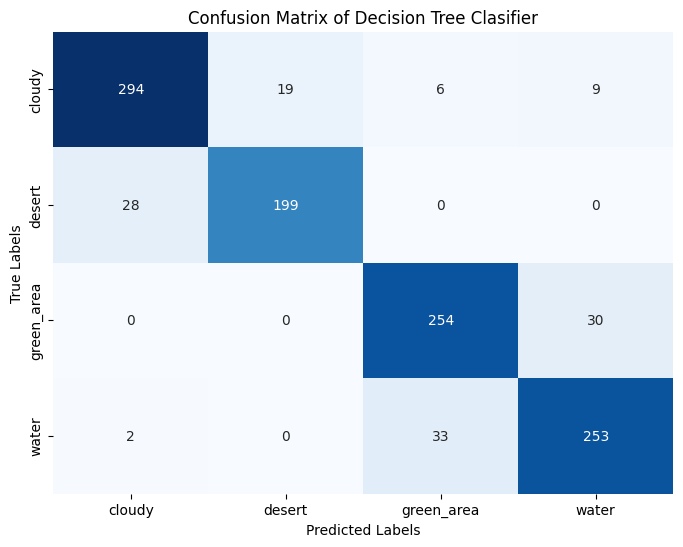

In [29]:
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(trainX, trainY)
predictions = treeclf.predict(testX)
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Decision Tree Clasifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

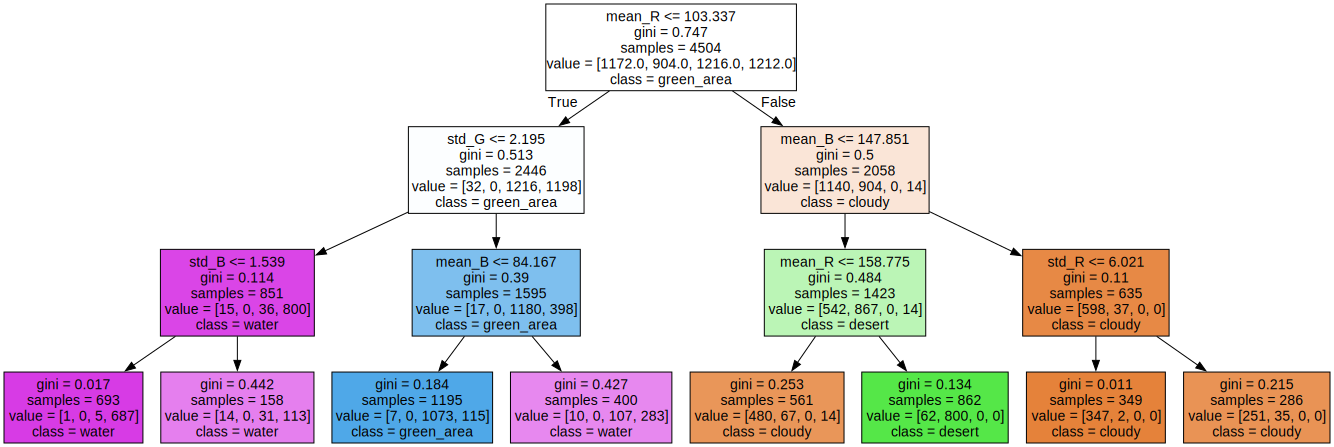

In [30]:
from sklearn import tree
graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B'],
                                    class_names=le.classes_, filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

In [18]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances
result = permutation_importance(treeclf, testX, testY, n_repeats=10, random_state=42)

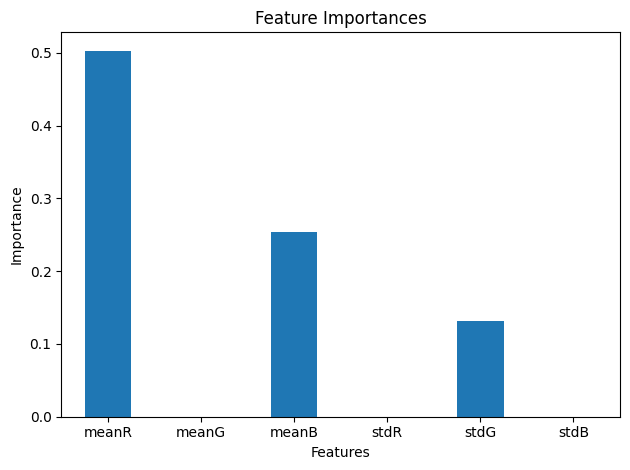

In [38]:
importances_mean = result['importances_mean']  # Replace with your actual result array
df_importances = pd.DataFrame(importances_mean, columns=["Importance"])
labels = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']
df_importances.plot(kind='bar', legend=False)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=0)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

In [45]:
from sklearn.neural_network import MLPClassifier
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

In [46]:
mlp = MLPClassifier(hidden_layer_sizes=(6, 5, 4),max_iter=500)

In [47]:
mlp.fit(trainX,trainY)

MLPClassifier(hidden_layer_sizes=(6, 5, 4), max_iter=500)

Confusion Matrix of Logistic Regression:
[[318   9   0   1]
 [  8 219   0   0]
 [  0   0 257  27]
 [  1   0  29 258]]


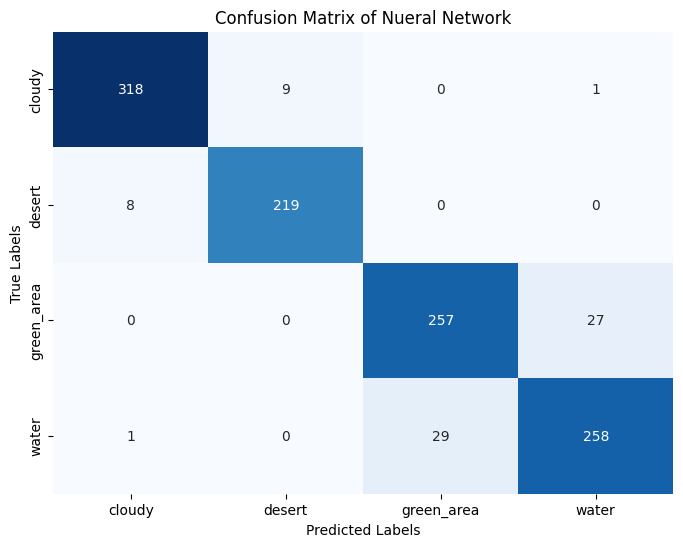

In [52]:
predictions = mlp.predict(testX)
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Logistic Regression:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Nueral Network")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [53]:
mlp.coefs_

[array([[-0.37872299,  0.597681  ,  1.73398356, -2.02357302, -0.39215869,
         -1.18911098],
        [-0.95370271,  0.48983812, -0.65681392, -0.10465463,  0.02793251,
         -0.64826667],
        [-0.70676778, -0.77404777, -0.55491314,  0.33563123, -1.46021172,
         -1.25899971],
        [-1.72321134,  0.17024198,  0.14239206, -0.05143464, -0.23715162,
         -0.28784688],
        [-1.43914736, -0.67205716, -0.10474998,  0.52884403,  0.41134077,
         -0.51818665],
        [-1.11370295,  0.13523233, -0.01817313, -1.04274741, -0.26325549,
          0.18308725]]),
 array([[ 7.73021646e-01, -8.14584184e-01, -3.15913573e-02,
          1.59820604e+00,  3.84627249e-01],
        [ 2.28115745e+00,  7.26386659e-01,  1.12787116e-01,
          2.04240777e-01, -7.55673191e-01],
        [ 1.62159132e+00,  4.64224285e-01, -5.11063240e-02,
         -6.65344384e-01, -2.17709720e-08],
        [-1.19881103e+00, -1.46061047e-01, -3.94215439e-01,
          1.90522389e+00, -1.12960175e-01],


Confusion Matrix of Neural Network:
[[313  10   2   3]
 [  4 223   0   0]
 [  0   0 276   8]
 [  0   0  25 263]]


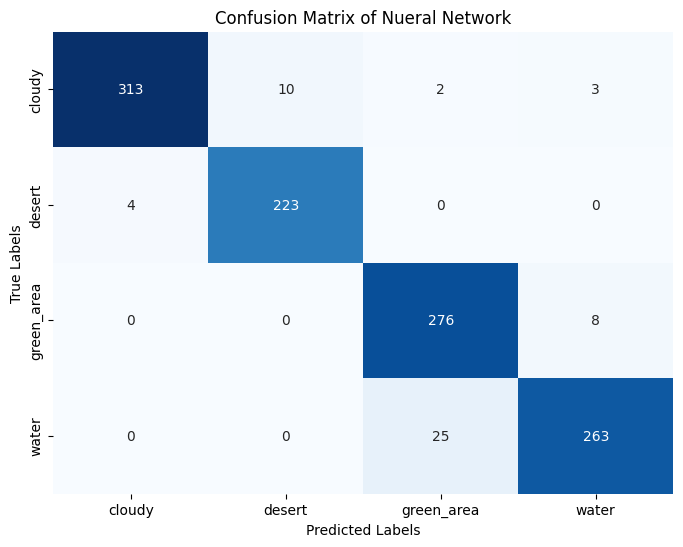

In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 8, 4),max_iter=500)
mlp.fit(trainX,trainY)
predictions = mlp.predict(testX)
conf_matrix = confusion_matrix(testY, predictions)
print("Confusion Matrix of Neural Network:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Nueral Network")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [70]:
trainY_one_hot = tf.keras.utils.to_categorical(trainY, num_classes=4)
testY_one_hot = tf.keras.utils.to_categorical(testY, num_classes=4)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(6, input_dim=6, activation='relu', name='InputLayer'),  # Input layer with 6 features
    tf.keras.layers.Dense(6, activation='relu', name='Hiddenlayer1'),
    tf.keras.layers.Dense(5, activation='relu', name='HiddenLayer2'),  # First hidden layer with 6 neurons
    tf.keras.layers.Dense(4, activation='relu', name='HiddenLayer3'),  # Second hidden layer with 5 neurons
    tf.keras.layers.Dense(4, activation='softmax', name='OutputLayer')  # Output layer with 4 neurons (for classification)
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Metric to monitor
                                                   patience=5,          # Number of epochs with no improvement before stopping
                                                   restore_best_weights=True)  # Restore the best model weights
history = model.fit(trainX, trainY_one_hot, epochs=50, validation_data=(testX, testY_one_hot),
                    verbose=1, callbacks=[early_stopping])

Epoch 1/20
141/141 [==============================] - 3s 3ms/step - loss: 1.3757 - accuracy: 0.2786
Epoch 2/20
141/141 [==============================] - 0s 3ms/step - loss: 1.2315 - accuracy: 0.4261
Epoch 3/20
141/141 [==============================] - 1s 4ms/step - loss: 1.0051 - accuracy: 0.5482
Epoch 4/20
141/141 [==============================] - 0s 3ms/step - loss: 0.7857 - accuracy: 0.6334
Epoch 5/20
141/141 [==============================] - 0s 3ms/step - loss: 0.6351 - accuracy: 0.6938
Epoch 6/20
141/141 [==============================] - 0s 3ms/step - loss: 0.5679 - accuracy: 0.7089
Epoch 7/20
141/141 [==============================] - 0s 3ms/step - loss: 0.5343 - accuracy: 0.7289
Epoch 8/20
141/141 [==============================] - 0s 3ms/step - loss: 0.5126 - accuracy: 0.7504
Epoch 9/20
141/141 [==============================] - 0s 3ms/step - loss: 0.4958 - accuracy: 0.7640
Epoch 10/20
141/141 [==============================] - 0s 3ms/step - loss: 0.4831 - accuracy: 0.7926

In [72]:
predictions = model.predict(testX)
predicted_labels = np.argmax(predictions, axis=1)


36/36 [==============================] - 0s 3ms/step


Confusion Matrix of Neural Network:
[[307  17   0   4]
 [  3 224   0   0]
 [  0   0 269  15]
 [  0   0  32 256]]


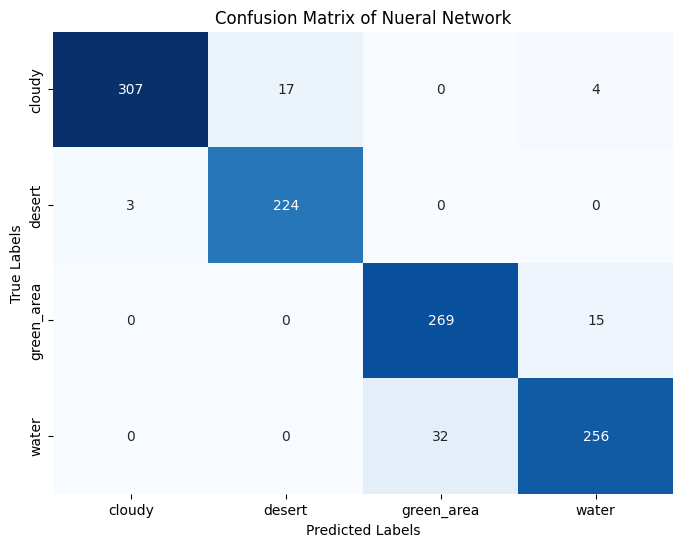

In [75]:
conf_matrix = confusion_matrix(testY, predicted_labels)
print("Confusion Matrix of Neural Network:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of Nueral Network")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [88]:
dot = graphviz.Digraph(format='png')
input_nodes = ['meanR', 'meanG', 'meanB', 'stdR', 'stdG', 'stdB']

# Hidden layers (6, 5, and 4 neurons)
hidden_nodes1 = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']
hidden_nodes2 = ['H7', 'H8', 'H9', 'H10', 'H11']
hidden_nodes3 = ['H12', 'H13', 'H14', 'H15']

# Output layer (4 neurons)
output_nodes = ['Cloudy', 'Desert', 'Green Area', 'Water']
weights_input_hidden = model.layers[0].get_weights()[0]  # Weights between input and hidden layer 1
weights_hidden_1_2 = model.layers[1].get_weights()[0]  # Weights between hidden layer 1 and 2
weights_hidden_2_3 = model.layers[2].get_weights()[0]  # Weights between hidden layer 2 and 3
weights_hidden_3_output = model.layers[3].get_weights()[0] 
# Add nodes for input, hidden, and output layers
for node in input_nodes:
    dot.node(node, node)

for node in hidden_nodes1:
    dot.node(node, node)

for node in hidden_nodes2:
    dot.node(node, node)

for node in hidden_nodes3:
    dot.node(node, node)

for node in output_nodes:
    dot.node(node, node)

# Add edges with weight magnitudes and colors between layers
def add_weighted_edges(input_nodes, next_nodes, weights):
    for i, input_node in enumerate(input_nodes):
        for j, next_node in enumerate(next_nodes):
            weight = weights[i][j]
            edge_color = 'red' if weight < 0 else 'blue'  # Red for negative, green for positive weights
            edge_thickness = abs(weight)**2  # Magnitude determines thickness
            dot.edge(input_node, next_node, color=edge_color, penwidth=str(edge_thickness))

# Add edges between input layer and hidden layer 1
add_weighted_edges(input_nodes, hidden_nodes1, weights_input_hidden)

# Add edges between hidden layer 1 and hidden layer 2
add_weighted_edges(hidden_nodes1, hidden_nodes2, weights_hidden_1_2)

# Add edges between hidden layer 2 and hidden layer 3
add_weighted_edges(hidden_nodes2, hidden_nodes3, weights_hidden_2_3)

# Add edges between hidden layer 3 and output layer
add_weighted_edges(hidden_nodes3, output_nodes, weights_hidden_3_output)

# Render the graph
dot.render('neural_network_with_weights', view=True)

'neural_network_with_weights.png'